In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [2]:
train_data = pd.read_csv(
    "/kaggle/input/e-commerce-shoppers-behaviour-understanding/train_data_v2.csv"
)

# Data Analysis

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14731 entries, 0 to 14730
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   HomePage                         14578 non-null  float64
 1   HomePage_Duration                14581 non-null  float64
 2   LandingPage                      14578 non-null  float64
 3   LandingPage_Duration             14596 non-null  float64
 4   ProductDescriptionPage           14608 non-null  float64
 5   ProductDescriptionPage_Duration  14564 non-null  float64
 6   GoogleMetric:Bounce Rates        14580 non-null  float64
 7   GoogleMetric:Exit Rates          14602 non-null  float64
 8   GoogleMetric:Page Values         14599 non-null  float64
 9   SeasonalPurchase                 14581 non-null  float64
 10  Month_SeasonalPurchase           14587 non-null  object 
 11  OS                               14597 non-null  float64
 12  SearchEngine      

In [4]:
feature = train_data.iloc[:, :-1]
label = train_data.iloc[:, -1]

In [5]:
label.value_counts()

False    9065
True     5666
Name: Made_Purchase, dtype: int64

In [6]:
feature.describe()

,HomePage,HomePage_Duration,LandingPage,LandingPage_Duration,ProductDescriptionPage,ProductDescriptionPage_Duration,GoogleMetric:Bounce Rates,GoogleMetric:Exit Rates,GoogleMetric:Page Values,SeasonalPurchase,OS,SearchEngine,Zone,Type of Traffic,WeekendPurchase
count,14578.000000,14581.000000,14578.000000,14596.000000,14608.000000,14564.000000,14580.000000,14602.000000,14599.000000,14581.000000,14597.000000,14609.000000,14614.000000,14588.000000,14610.000000
mean,2.250240,79.300762,0.490739,33.455943,31.559488,1184.346084,0.023366,0.044664,4.812620,0.064083,2.122422,2.356629,3.155673,4.090143,0.234155
std,3.288042,179.374699,1.252376,140.146256,44.897089,2009.496307,0.050011,0.049912,16.887366,0.202583,0.914404,1.721823,2.405155,4.040147,0.423484
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,173.187500,0.000000,0.014502,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,0.000000
50%,1.000000,5.000000,0.000000,0.000000,17.500000,584.333333,0.003478,0.026406,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,0.000000
75%,3.000000,91.000000,0.000000,0.000000,38.000000,1434.255128,0.018182,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000,1.000000


In [7]:
cat_features = [col for col in train_data.columns if train_data[col].dtype == object]

print("Total categorical features:", len(cat_features))

num_features = [
    col for col in train_data.columns if train_data[col].dtype not in (object, bool)
]

print("Total numerical features:", len(num_features))

Total categorical features: 6
Total numerical features: 15


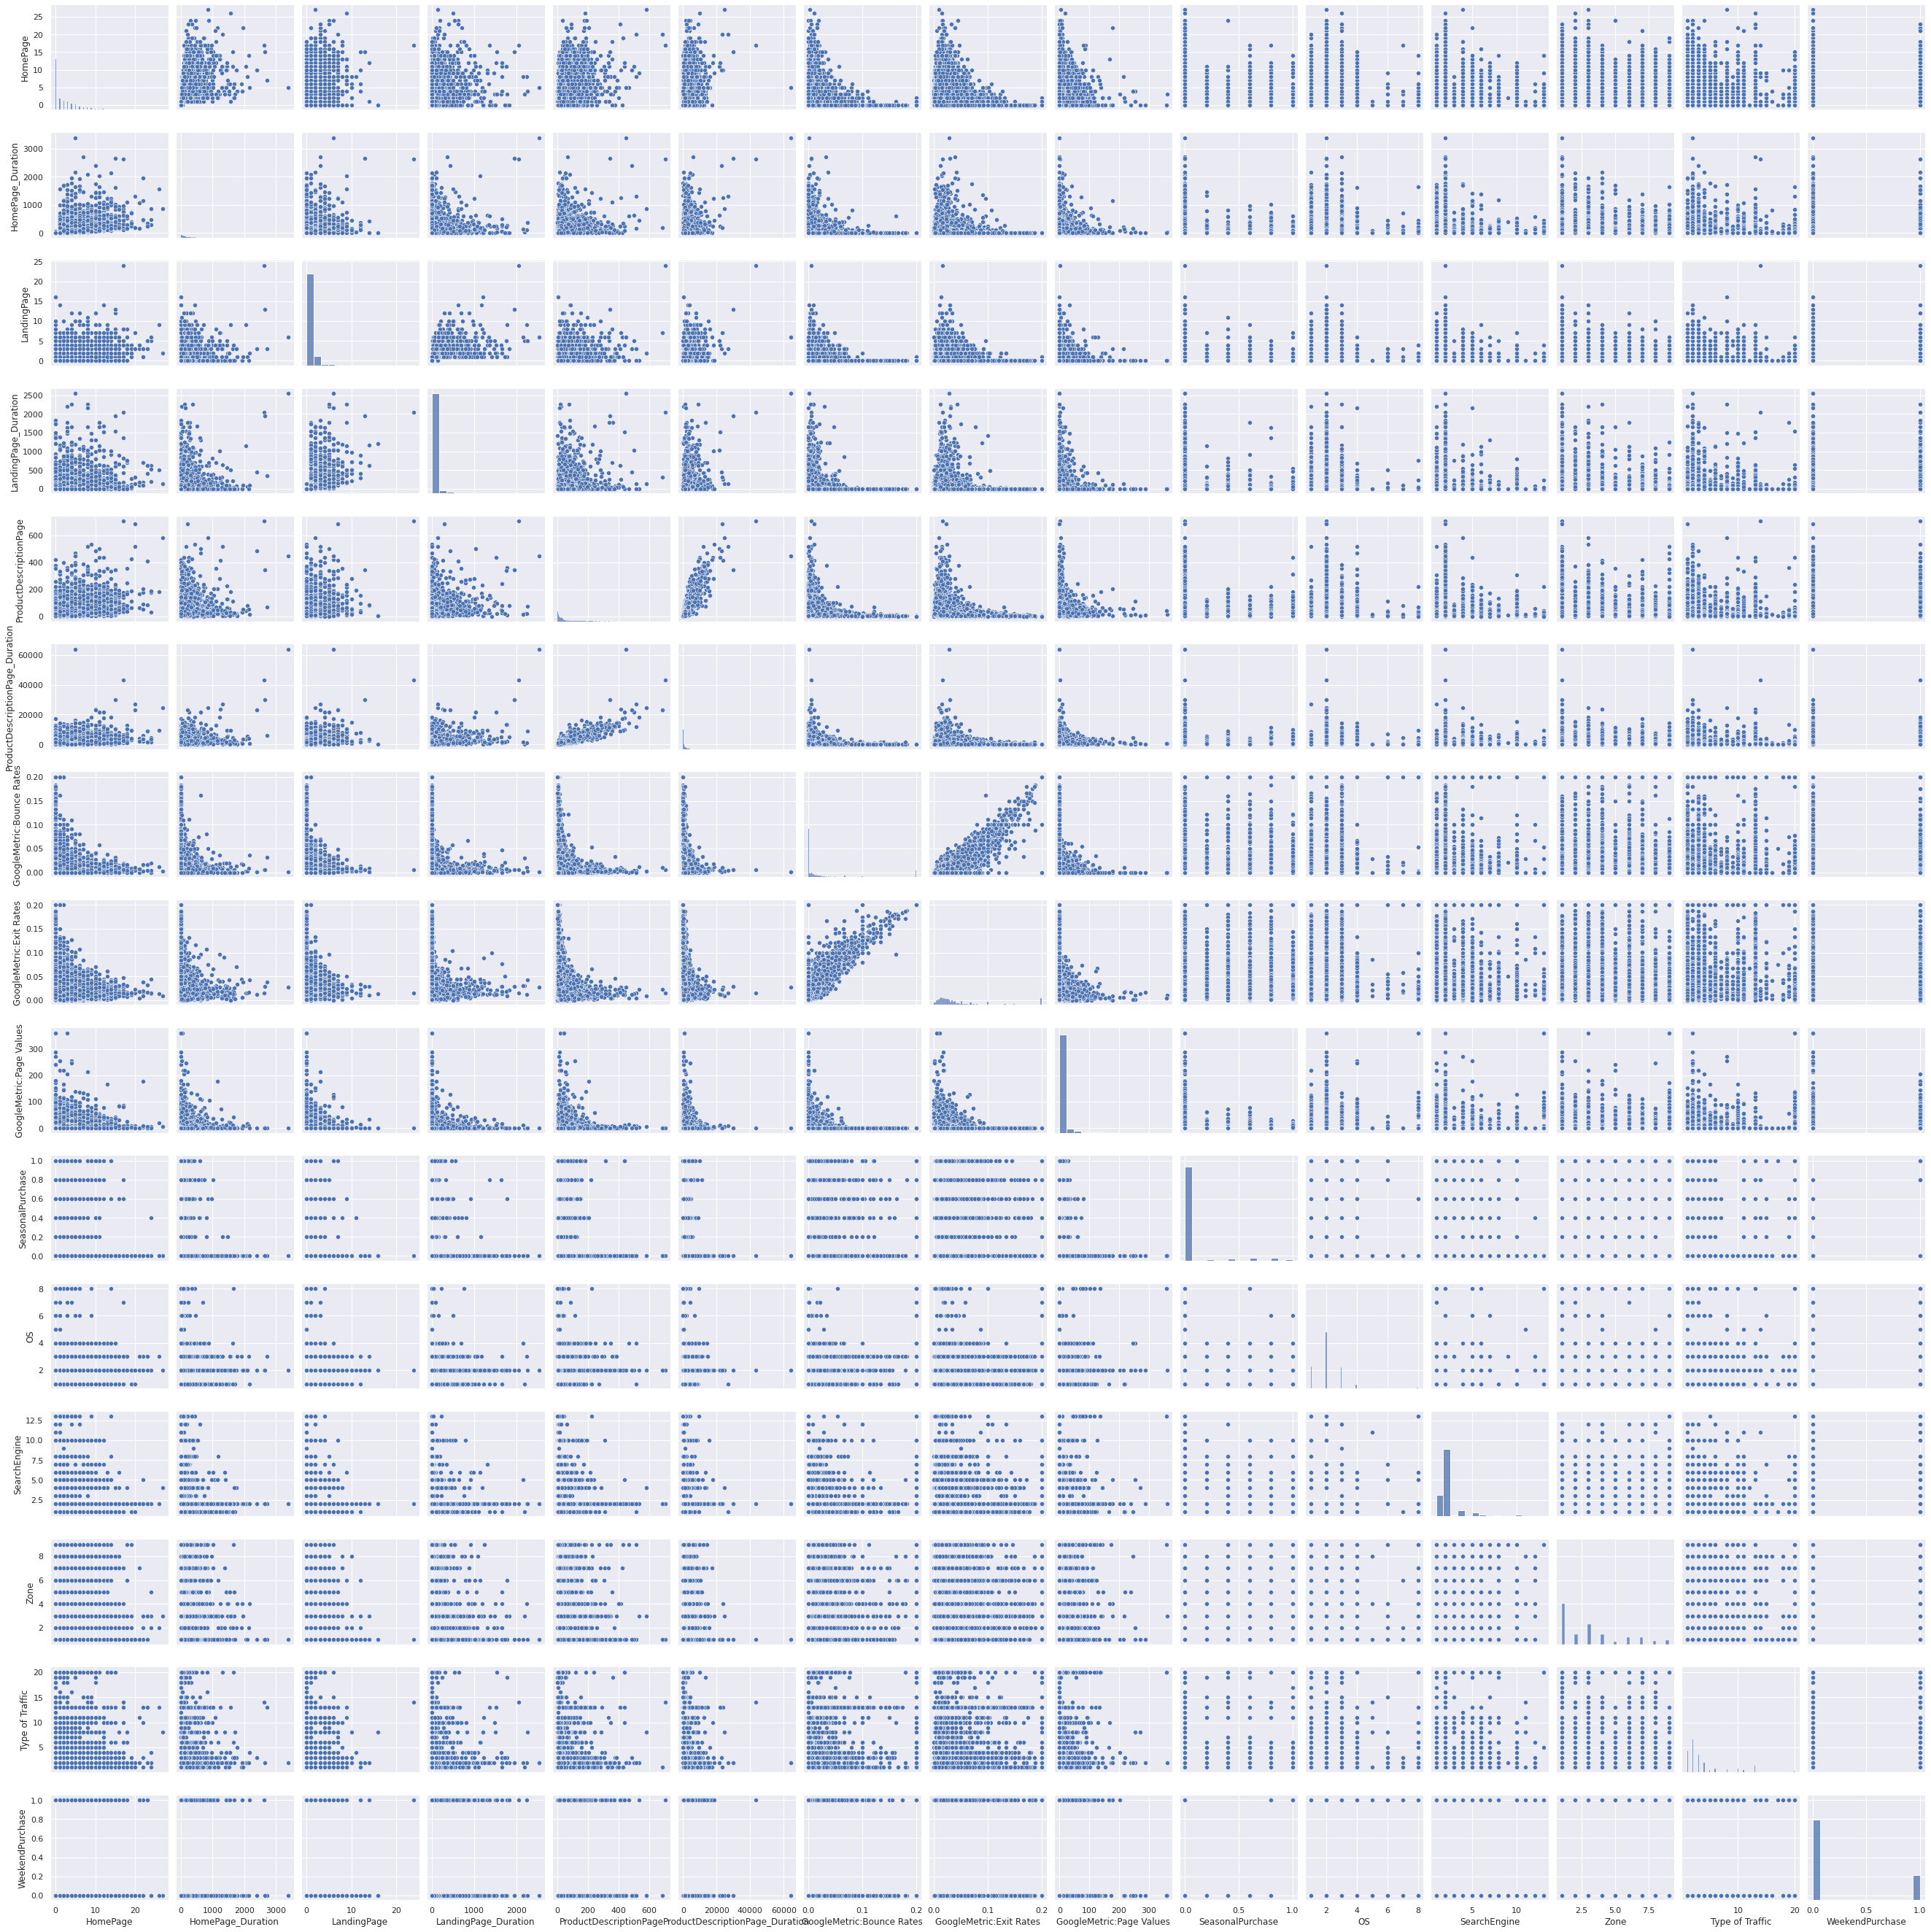

In [8]:
sns.set(rc={'figure.figsize':(12,8)})
sns.pairplot(feature[num_features])

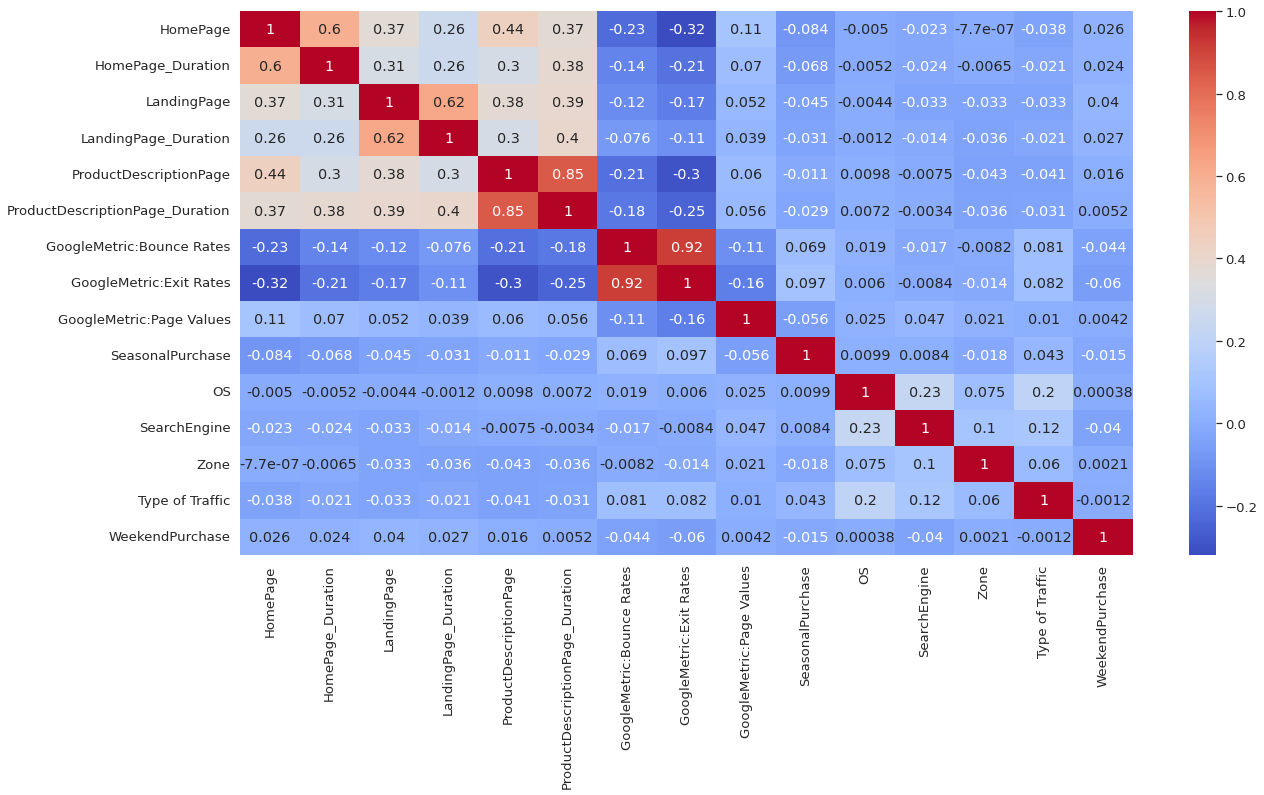

In [9]:
corr_mat = feature[num_features].corr()
sns.set(font_scale=1.2)
plt.figure(figsize=(20, 10))
sns.heatmap(corr_mat, cmap='coolwarm', annot=True)
plt.show()

### Removing Features that are highly correlated

* Avoiding multicollinearity
* Reducing overfitting

In [10]:
num_features = [_ for _ in num_features if _ not in ('GoogleMetric:Exit Rates', 'ProductDesciptionPage', 'LandingPage')]
num_features

['HomePage',
 'HomePage_Duration',
 'LandingPage_Duration',
 'ProductDescriptionPage',
 'ProductDescriptionPage_Duration',
 'GoogleMetric:Bounce Rates',
 'GoogleMetric:Page Values',
 'SeasonalPurchase',
 'OS',
 'SearchEngine',
 'Zone',
 'Type of Traffic',
 'WeekendPurchase']

### Data Preparation and Preprocessing

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(feature, label, test_size=0.2)

In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [13]:
num_pipeline = Pipeline(
    [
        ("imputer", IterativeImputer()),
        ("scaler", StandardScaler())
    ]
)

cat_pipeline = Pipeline(
    [
        ("encoder", OneHotEncoder()),
    ]
)

In [14]:
preprocessing_pipe = ColumnTransformer(
    [
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_features)
    ]
)

preprocessing_pipe

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  IterativeImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['HomePage', 'HomePage_Duration',
                                  'LandingPage_Duration',
                                  'ProductDescriptionPage',
                                  'ProductDescriptionPage_Duration',
                                  'GoogleMetric:Bounce Rates',
                                  'GoogleMetric:Page Values',
                                  'SeasonalPurchase', 'OS', 'SearchEngine',
                                  'Zone', 'Type of Traffic',
                                  'WeekendPurchase']),
                                ('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 ['Month_SeasonalPurcha

# SVM using SGD

In [15]:
# from sklearn.linear_model import SGDClassifier

# clf = Pipeline(
#     [
#         ("preprocessing", preprocessing_pipe),
#         ("SGD", SGDClassifier(
#                 eta0=0.001,
#                 loss="hinge"
#             )
#         )
#     ]
# )

### Hinge loss : L(y, f(x)) = max(0, 1 - y * f(x))

In [16]:
# clf.fit(X_train, y_train)

In [17]:
# clf.score(X_val, y_val) 
print("""
    score - 0.6477
""" )


    score - 0.6477



## Hyperparam tuning of SVM using Grid Search

In [18]:
# param_grid = {
#     "SGD__penalty": ['l2','l1','elasticnet','None'],
#     "SGD__alpha": np.logspace(-4, 4, 10),
#     "SGD__learning_rate": ["optimal"],
#     "SGD__early_stopping": [True],
#     "SGD__warm_start": [True]    
# }

In [19]:
# grid_clf = GridSearchCV(
#     clf,
#     param_grid=param_grid,
#     cv=cv,
#     refit=True,
#     n_jobs=2,
#     verbose=3,
#     return_train_score=True
# )

In [20]:
# svm_best_estimator = grid_clf.best_estimator_
# svm_best_estimator.fit(X_train, y_train)
# svm_best_estimator.score(X_val, y_val) 
print("""
    SCORE = 0.6513396089790008
""")


    SCORE = 0.6513396089790008



In [21]:
# grid_clf.best_params_
print("""
    alpha=0.005994842503189409,
    early_stopping=True,
    learning_rate="optimal",
    penalty="l2",
    warm_start=True
""")


    alpha=0.005994842503189409,
    early_stopping=True,
    learning_rate="optimal",
    penalty="l2",
    warm_start=True



In [22]:
# clf = Pipeline(
#     [
#         ("preprocessing", preprocessing_pipe),
#         ("SGD", SGDClassifier(
#                 eta0=0.001,
#                 alpha=0.005994842503189409,
#                 early_stopping=True,
#                 learning_rate="optimal",
#                 penalty="l2",
#                 warm_start=True,
#             )
#         )
#     ]
# )

In [23]:
# clf.fit(X_train, y_train)
# clf.score(X_val, y_val)

In [24]:
# y_val_predictions = clf.predict(X_val)

In [25]:
# print(classification_report(y_val, y_val_predictions))

### Classification Report for SVM(fine tuned) using Gradient Descent

                  precision    recall  f1-score   support

           False       0.65      0.95      0.77      1803
            True       0.72      0.18      0.29      1144

        accuracy                           0.65      2947
       macro avg       0.68      0.57      0.53      2947
    weighted avg       0.67      0.65      0.58      2947

# Logistic Regression


### Loss function : L(y, f(x)) = -[y * log(p) + (1 - y) * log(1 - p)]
#### p -> sigmoid(f(x))

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
# clf = Pipeline(
#     [
#         ("preprocessing", preprocessing_pipe),
#         ("logit", LogisticRegression(solver='newton-cg')
#         )
#     ]
# )

In [28]:
# clf.fit(X_train, y_train)

In [29]:
# clf.score(X_val, y_val)

print("""
    score - 0.658635900916186
""")


    score - 0.658635900916186



### Performing Cross Validation
#### Assessing the performance of the model on unseen data by training on one fold and testing across different folds

In [30]:
# from sklearn.model_selection import cross_validate
# from sklearn.model_selection import StratifiedShuffleSplit

# cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25)

# scores = cross_validate(clf, X_train, y_train, cv=cv)

In [31]:
# scores

print("""
    'test_score': array([0.65274949, 0.65342838, 0.66395112, 0.65274949, 0.6496945 ,
        0.65274949, 0.66191446, 0.65682281, 0.66564834, 0.65342838]
""")


    'test_score': array([0.65274949, 0.65342838, 0.66395112, 0.65274949, 0.6496945 ,
        0.65274949, 0.66191446, 0.65682281, 0.66564834, 0.65342838]



In [32]:
# print(np.mean(scores['test_score']))
print("""
    score - 0.6563136456211812
""")


    score - 0.6563136456211812



In [33]:
# y_val_predictions = clf.predict(X_val)
# print(classification_report(y_val, y_val_predictions))

### Classification report for Logistic Regression

               precision    recall  f1-score   support
 
           False       0.65      0.96      0.78      1803
            True       0.75      0.18      0.29      1144

        accuracy                           0.66      2947
       macro avg       0.70      0.57      0.53      2947
    weighted avg       0.69      0.66      0.59      2947

In [34]:
# param_grid = {
#     'logit__penalty': ['l1', 'l2'],
#     'logit__C': [0.1, 1],
#     'logit__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# }

In [35]:
# grid_clf = GridSearchCV(
#     clf,
#     param_grid=param_grid,
#     cv=cv,
#     refit=True,
#     n_jobs=2,
#     verbose=2,
#     return_train_score=True
# )

In [36]:
# grid_clf.best_params_
print("""
    solver="saga", C=0.1, penalty="l1"
""")


    solver="saga", C=0.1, penalty="l1"



# Adaptive Boosting (AdaBoost)

### Using weak learners and focusing on misclassified examples from previous epoch to get a strong learner

In [37]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [38]:
# clf = Pipeline(
#     [
#         ("preprocessing", preprocessing_pipe),
#         (
#             "boost",
#             AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1)), # Just One decision stump
#         ),
#     ]
# )

In [39]:
# clf.fit(X_train, y_train)
# clf.score(X_val, y_val)
print("""
    score - 0.6562606040040719
""")


    score - 0.6562606040040719



### Hyperparam Tuning

In [40]:
# param_grid = {
#     "boost__n_estimators": [150, 200, 250],
#     "boost__learning_rate": [0.04, 0.045, 0.05],
#     "boost__algorithm": ["SAMME"],
# }

In [41]:
# grid_clf = GridSearchCV(
#     clf,
#     param_grid=param_grid,
#     cv=5,
#     # refit=True,
#     n_jobs=10,
#     return_train_score=True,
#     verbose=2,
# )

In [42]:
# grid_clf.best_params_
print("""
{'boost__algorithm': 'SAMME',
 'boost__learning_rate': 0.045,
 'boost__n_estimators': 250}
 """)


{'boost__algorithm': 'SAMME',
 'boost__learning_rate': 0.045,
 'boost__n_estimators': 250}
 


In [43]:
clf = Pipeline(
    [
        ("preprocessing", preprocessing_pipe),
        (
            "boost",
            AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                              algorithm='SAMME', learning_rate=0.045, n_estimators=250),
        ),
    ]
)

In [44]:
clf.fit(X_train, y_train)
# clf.score(X_val, y_val)
print("""
    score - 0.668815744825246
""")


    score - 0.668815744825246



In [45]:
# y_val_predictions = clf.predict(X_val)
# print(classification_report(y_val, y_val_predictions))

### Clasification Report for AdaBoost Classifier                  
                  precision    recall  f1-score   support

           False       0.67      0.91      0.77      1803
            True       0.67      0.29      0.40      1144

       accuracy                           0.67      2947
       macro avg       0.67      0.60      0.59      2947
    weighted avg       0.67      0.67      0.63      2947

### Performing Cross Validation

In [46]:
# from sklearn.model_selection import cross_validate
# from sklearn.model_selection import StratifiedShuffleSplit

# cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25)

# scores = cross_validate(clf, X_train, y_train, cv=cv)

In [47]:
# scores
print("""
    'test_score': array([0.66836388, 0.66666667, 0.65580448, 0.67684997, 0.66564834,
        0.66429056, 0.66734555, 0.66055669, 0.67073999, 0.66327223]
""")


    'test_score': array([0.66836388, 0.66666667, 0.65580448, 0.67684997, 0.66564834,
        0.66429056, 0.66734555, 0.66055669, 0.67073999, 0.66327223]



### Feature Importances (w.r.t. AdaBoost)

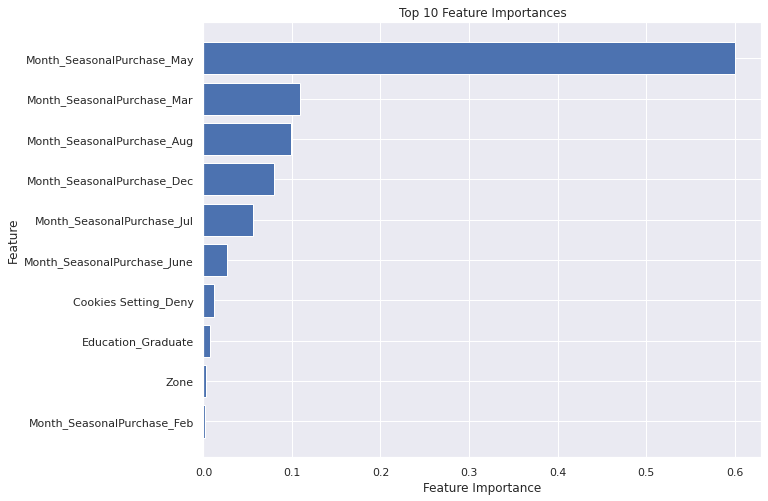

In [48]:
sns.set()
importances = clf.named_steps['boost'].feature_importances_
feature_names = clf.named_steps['preprocessing'].transformers_[1][1]['encoder'].get_feature_names_out(cat_features)
feature_names = np.concatenate([feature_names, np.array(num_features)])


sorted_idx = np.argsort(importances)
sorted_importances = importances[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

top_n = 10
top_importances = sorted_importances[-top_n:]
top_feature_names = sorted_feature_names[-top_n:]

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(top_importances)), top_importances)
ax.set_yticks(range(len(top_importances)))
ax.set_yticklabels(top_feature_names)
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature')
ax.set_title('Top {} Feature Importances'.format(top_n))
plt.show()

In [49]:
sns.reset_defaults()

# Stacking Classifier

In [50]:
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import NearestCentroid
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

In [51]:
estimators = [
    ("rf", RandomForestClassifier(n_estimators=500, max_features="log2", random_state=42)),
    (
        "gb",
        GradientBoostingClassifier(
            warm_start=True,
            tol=0.0001,
            n_iter_no_change=5,
            n_estimators=200,
            min_samples_split=4,
            min_samples_leaf=1,
            max_features=None,
            max_depth=3,
            learning_rate=0.015,
            criterion="friedman_mse",
        ),
    ),
    (
        "logit",
        LogisticRegression(
            solver="saga", C=0.1, penalty="l2", multi_class="multinomial", max_iter=2000
        ),
    ),
    (
        "svc",
        SVC(C=10, degree=2, gamma=0.01, kernel="rbf", probability=True),
    ),
    ("nb", BernoulliNB()),
    ("nc", NearestCentroid())
]

In [52]:
clf = Pipeline(
    [
        ("preprocessing", preprocessing_pipe),
        (
            "stacking",
            StackingClassifier(
                estimators=estimators,
                final_estimator=AdaBoostClassifier(
                    DecisionTreeClassifier(max_depth=2),
                    learning_rate=0.05,
                ),
                passthrough=True,
                stack_method="auto",
                cv=StratifiedKFold(n_splits=5, shuffle=True),
                n_jobs=-1,
            ),
        ),
    ]
)

In [53]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HomePage',
                                                   'HomePage_Duration',
                                                   'LandingPage_Duration',
                                                   'ProductDescriptionPage',
                                                   'ProductDescriptionPage_Duration',
                                                   'GoogleMetric:Bounce Rates',
                                                   'GoogleMetric:Page Values',
                                              

# Final Estimator Performance Report

In [54]:
clf.score(X_val, y_val)

0.7641669494401085

### Cross Validation

In [55]:
# cv = StratifiedKFold(n_splits=10)

# scores = cross_validate(clf, X_train, y_train, cv=cv)

In [56]:
# print(scores)
print("""
{'fit_time': array([288.19319415, 284.57357907, 291.0321691 , 291.30644655,
       287.25640202, 285.33764768, 285.95603442, 285.18336248,
       286.99422359, 284.50722146]), 'score_time': array([1.46451616, 1.4455204 , 1.43969584, 1.47446084, 1.44620371,
       1.42672634, 1.44548154, 1.43830585, 1.46072531, 1.43265057]), 'test_score': array([0.75148431, 0.74639525, 0.76420696, 0.75402884, 0.75466893,
       0.77164686, 0.75721562, 0.75891341, 0.75976231, 0.76485569])}
""")


{'fit_time': array([288.19319415, 284.57357907, 291.0321691 , 291.30644655,
       287.25640202, 285.33764768, 285.95603442, 285.18336248,
       286.99422359, 284.50722146]), 'score_time': array([1.46451616, 1.4455204 , 1.43969584, 1.47446084, 1.44620371,
       1.42672634, 1.44548154, 1.43830585, 1.46072531, 1.43265057]), 'test_score': array([0.75148431, 0.74639525, 0.76420696, 0.75402884, 0.75466893,
       0.77164686, 0.75721562, 0.75891341, 0.75976231, 0.76485569])}



In [57]:
# print(np.mean(scores['test_score']))
print("""
0.7583178170329378
""")


0.7583178170329378



In [58]:
y_val_predictions = clf.predict(X_val)
print(classification_report(y_val, y_val_predictions))

              precision    recall  f1-score   support

       False       0.77      0.87      0.82      1772
        True       0.76      0.60      0.67      1175

    accuracy                           0.76      2947
   macro avg       0.76      0.74      0.74      2947
weighted avg       0.76      0.76      0.76      2947



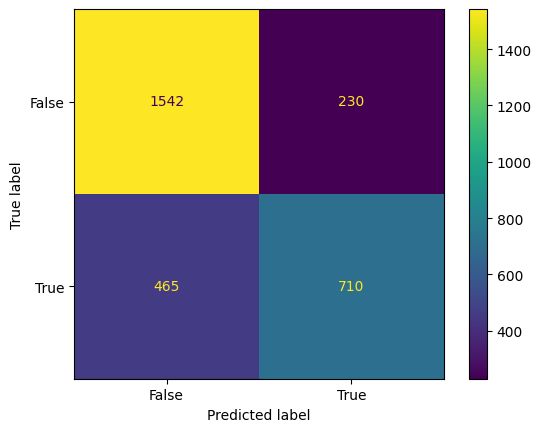

In [59]:
fig = ConfusionMatrixDisplay.from_predictions(y_val, y_val_predictions)
plt.show()

### Precision Recall Curve and ROC Curve

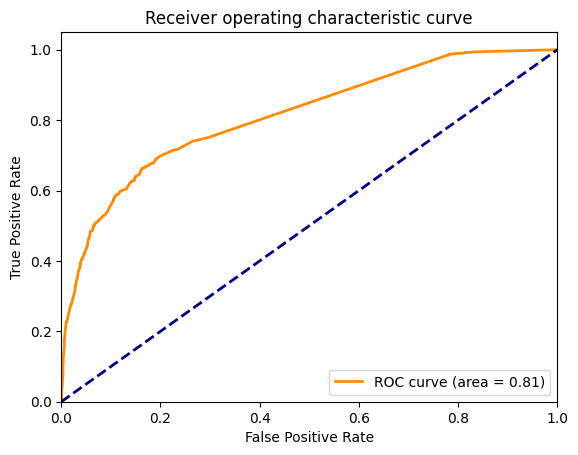

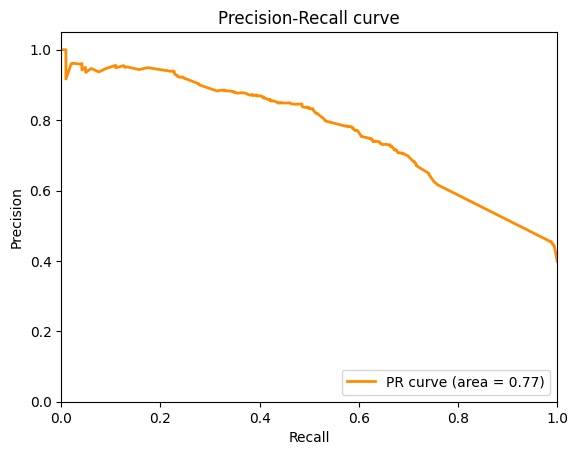

In [60]:
from sklearn.metrics import auc, precision_recall_curve, roc_curve

y_score = clf.predict_proba(X_val)[:, 1]
y_true = y_val

# Computing ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Computing precision-recall curve and area for each class
precision, recall, _ = precision_recall_curve(y_true, y_score)
pr_auc = auc(recall, precision)

# Plotting ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic curve")
plt.legend(loc="lower right")
plt.show()

# Plotting PR curve
plt.figure()
plt.plot(
    recall,
    precision,
    color="darkorange",
    lw=2,
    label="PR curve (area = %0.2f)" % pr_auc,
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.legend(loc="lower right")
plt.show()

In [61]:
test_data = pd.read_csv("/kaggle/input/e-commerce-shoppers-behaviour-understanding/test_data_v2.csv")

In [62]:
y_hat_test_pred = clf.predict(test_data)

In [63]:
y_hat_test_pred = ["True" if _ == 1 else "False" for _ in y_hat_test_pred ]

In [64]:
submission_df = pd.DataFrame({"id": range(len(y_hat_test_pred)),
                              "Made_Purchase": y_hat_test_pred})

submission_df.to_csv("submission.csv", index=False)